In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df_delivery = pd.read_csv('../01_CSV Trabajo/data_analisis.csv')

In [5]:
df_delivery.head()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders,delivery_duration,partner_density,order_day,order_hour,order_period,busy_ratio,avg_item_price,order_size,grouped_category
0,4,3441,4,557.0,1239,33.0,14.0,21.0,3779.0,1.500000,Friday,22,Night,0.411765,860.25,Medium,American
1,1,1900,1,1400.0,1400,1.0,2.0,2.0,4024.0,0.333333,Tuesday,21,Evening,1.000000,1900.00,Small,Mexican
2,4,4771,3,820.0,1604,8.0,6.0,18.0,1586.0,0.421053,Monday,0,Night,0.666667,1192.75,Medium,Indian
3,1,1525,1,1525.0,1525,5.0,6.0,8.0,2273.0,0.555556,Thursday,3,Night,1.000000,1525.00,Small,Italian
4,2,3620,2,1425.0,2195,5.0,5.0,7.0,2988.0,0.625000,Tuesday,2,Night,0.833333,1810.00,Small,Italian


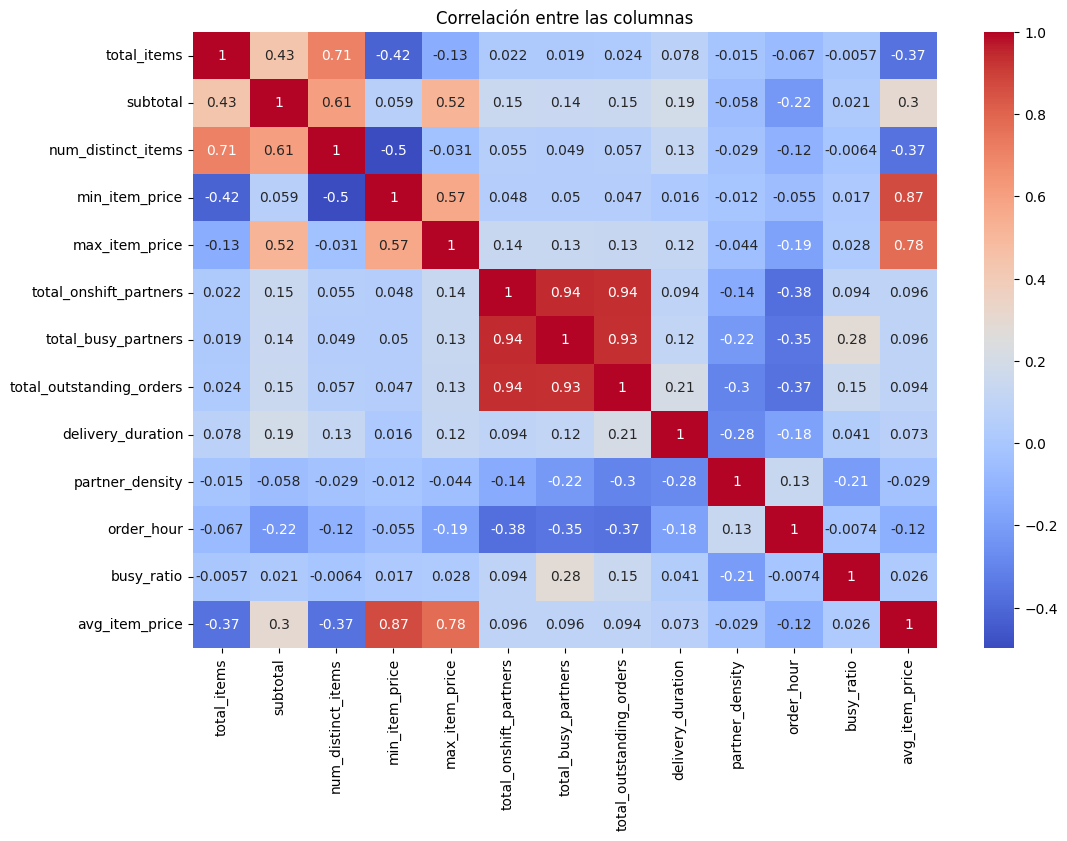

  order_day  order_hour grouped_category  delivery_duration
0    Friday          22         American             3779.0
1   Tuesday          21          Mexican             4024.0
2    Monday           0           Indian             1586.0
3  Thursday           3          Italian             2273.0
4   Tuesday           2          Italian             2988.0


In [6]:
# Visualizamos las relaciones entre las columnas relevantes
plt.figure(figsize=(12, 8))
numerical_columns = df_delivery.select_dtypes(include=['float64', 'int64']).columns
sns.heatmap(df_delivery[numerical_columns].corr(), annot=True, cmap='coolwarm')
plt.title('Correlación entre las columnas')
plt.show()

# Identificamos y eliminamos los outliers en la columna 'delivery_duration'
q1 = df_delivery['delivery_duration'].quantile(0.25)
q3 = df_delivery['delivery_duration'].quantile(0.75)
iqr = q3 - q1
limite_inferior = q1 - 1.5 * iqr
limite_superior = q3 + 1.5 * iqr

df_delivery = df_delivery[(df_delivery['delivery_duration'] >= limite_inferior) & (df_delivery['delivery_duration'] <= limite_superior)]

# Seleccionamos las columnas relevantes para el estudio
columnas_relevantes = ['order_day', 'order_hour', 'grouped_category', 'delivery_duration']
df_delivery_relevante = df_delivery[columnas_relevantes]

# Visualizamos el dataframe limpio y preparado
print(df_delivery_relevante.head())

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor

# Seleccionamos las características y la variable objetivo
X = df_delivery_relevante[['order_hour', 'grouped_category']]
y = df_delivery_relevante['delivery_duration']

# Convertimos las variables categóricas en variables dummy
X = pd.get_dummies(X, drop_first=True)

# Dividimos los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenamos el modelo de regresión lineal
model = LinearRegression()
model.fit(X_train, y_train)

# Realizamos predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

# Evaluamos el modelo utilizando R²
r2 = r2_score(y_test, y_pred)
print(f'R²: {r2:.2f}')

# Si el R² es inferior a 0.80, podemos probar con otros modelos o ajustar los hiperparámetros
if r2 < 0.80:
    print("El R² es inferior a 0.80, probando con otros modelos...")

    # Entrenamos un modelo de Random Forest
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)

    # Realizamos predicciones en el conjunto de prueba
    y_pred_rf = rf_model.predict(X_test)

    # Evaluamos el modelo utilizando R²
    r2_rf = r2_score(y_test, y_pred_rf)
    print(f'R² con Random Forest: {r2_rf:.2f}')

R²: 0.04
El R² es inferior a 0.80, probando con otros modelos...
R² con Random Forest: 0.09


In [8]:
from sklearn.ensemble import GradientBoostingRegressor

# Entrenamos un modelo de Gradient Boosting
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)

# Realizamos predicciones en el conjunto de prueba
y_pred_gb = gb_model.predict(X_test)

# Evaluamos el modelo utilizando R²
r2_gb = r2_score(y_test, y_pred_gb)
print(f'R² con Gradient Boosting: {r2_gb:.2f}')

R² con Gradient Boosting: 0.09


In [9]:
from sklearn.model_selection import GridSearchCV

# Definimos los parámetros que queremos probar
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

# Creamos el modelo de Gradient Boosting
gb_model = GradientBoostingRegressor(random_state=42)

# Configuramos GridSearchCV
grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid, cv=3, n_jobs=-1, scoring='r2')

# Entrenamos el modelo con GridSearchCV
grid_search.fit(X_train, y_train)

# Obtenemos los mejores parámetros
best_params = grid_search.best_params_
print(f'Mejores parámetros: {best_params}')

# Entrenamos el modelo con los mejores parámetros
best_gb_model = GradientBoostingRegressor(**best_params, random_state=42)
best_gb_model.fit(X_train, y_train)

# Realizamos predicciones en el conjunto de prueba
y_pred_best_gb = best_gb_model.predict(X_test)

# Evaluamos el modelo utilizando R²
r2_best_gb = r2_score(y_test, y_pred_best_gb)
print(f'R² con Gradient Boosting ajustado: {r2_best_gb:.2f}')

Mejores parámetros: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100}
R² con Gradient Boosting ajustado: 0.09


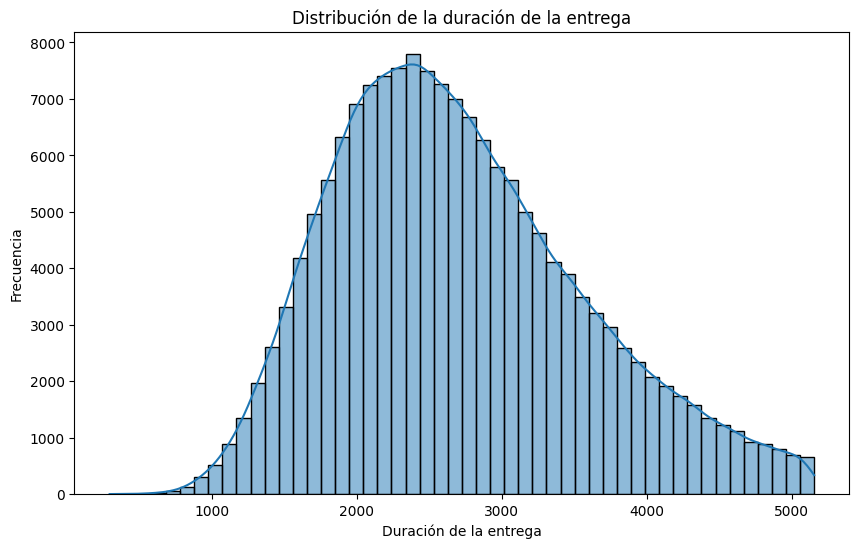

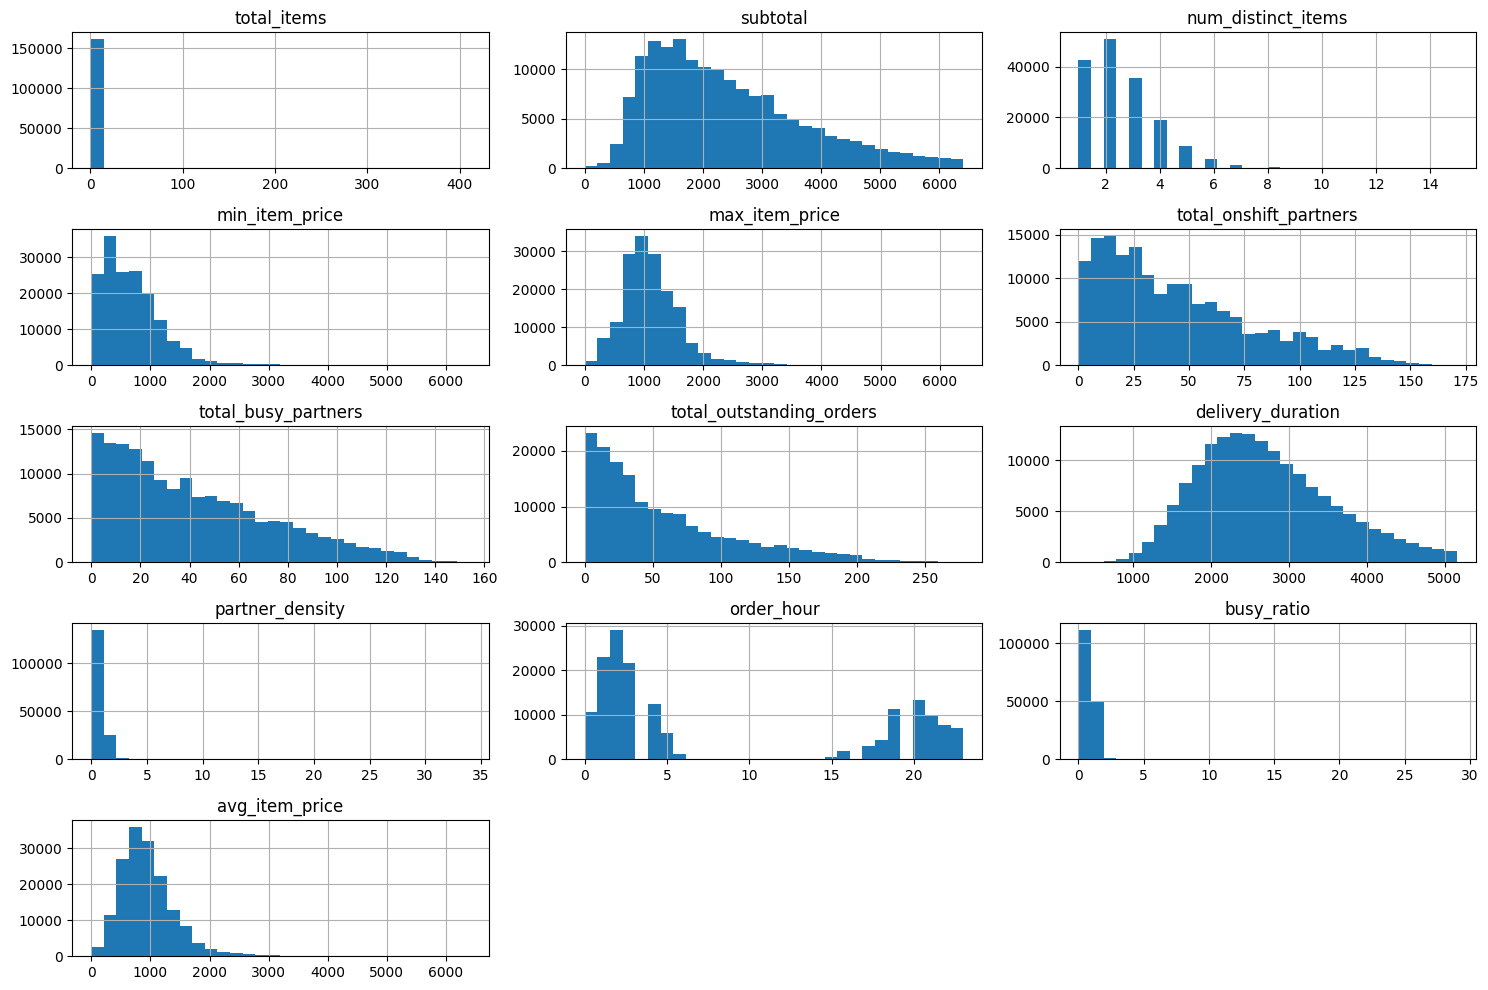

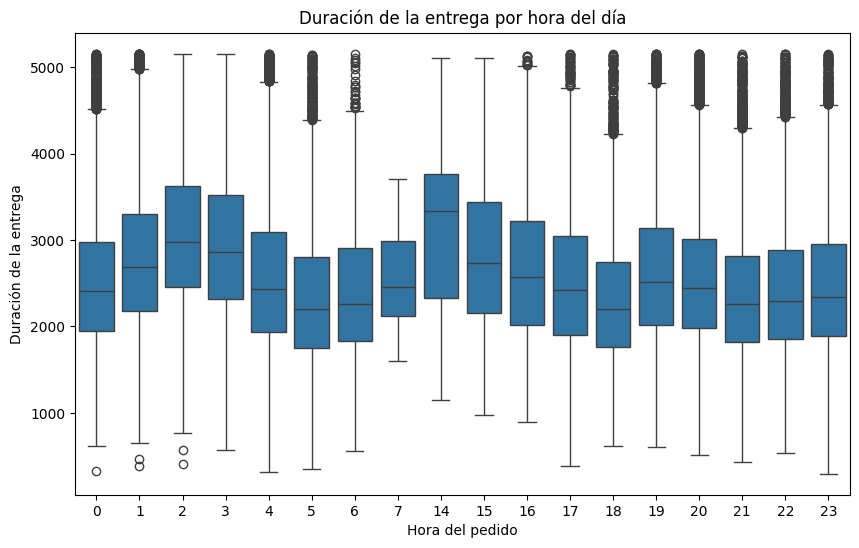

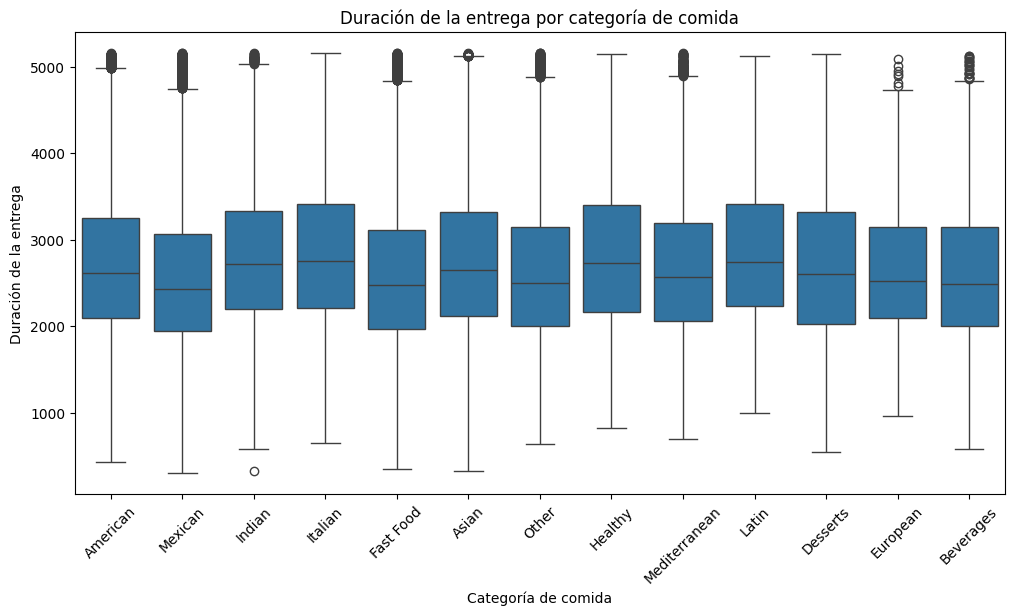

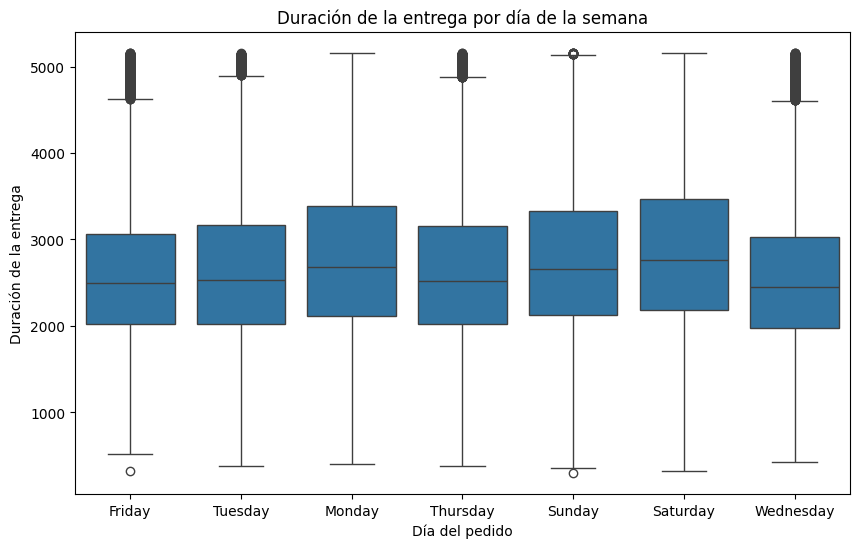

In [10]:
# Visualizamos la distribución de la variable objetivo 'delivery_duration'
plt.figure(figsize=(10, 6))
sns.histplot(df_delivery['delivery_duration'], bins=50, kde=True)
plt.title('Distribución de la duración de la entrega')
plt.xlabel('Duración de la entrega')
plt.ylabel('Frecuencia')
plt.show()

# Visualizamos la distribución de las variables numéricas
df_delivery[numerical_columns].hist(bins=30, figsize=(15, 10), layout=(5, 3))
plt.tight_layout()
plt.show()

# Visualizamos la relación entre 'order_hour' y 'delivery_duration'
plt.figure(figsize=(10, 6))
sns.boxplot(x='order_hour', y='delivery_duration', data=df_delivery)
plt.title('Duración de la entrega por hora del día')
plt.xlabel('Hora del pedido')
plt.ylabel('Duración de la entrega')
plt.show()

# Visualizamos la relación entre 'grouped_category' y 'delivery_duration'
plt.figure(figsize=(12, 6))
sns.boxplot(x='grouped_category', y='delivery_duration', data=df_delivery)
plt.title('Duración de la entrega por categoría de comida')
plt.xlabel('Categoría de comida')
plt.ylabel('Duración de la entrega')
plt.xticks(rotation=45)
plt.show()

# Visualizamos la relación entre 'order_day' y 'delivery_duration'
plt.figure(figsize=(10, 6))
sns.boxplot(x='order_day', y='delivery_duration', data=df_delivery)
plt.title('Duración de la entrega por día de la semana')
plt.xlabel('Día del pedido')
plt.ylabel('Duración de la entrega')
plt.show()

In [11]:
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# Identificamos y eliminamos los outliers en las variables relevantes
for column in columnas_relevantes:
    if df_delivery[column].dtype in ['float64', 'int64']:
        q1 = df_delivery[column].quantile(0.25)
        q3 = df_delivery[column].quantile(0.75)
        iqr = q3 - q1
        limite_inferior = q1 - 1.5 * iqr
        limite_superior = q3 + 1.5 * iqr
        df_delivery = df_delivery[(df_delivery[column] >= limite_inferior) & (df_delivery[column] <= limite_superior)]

# Seleccionamos las características y la variable objetivo
X = df_delivery_relevante[['order_hour', 'grouped_category']]
y = df_delivery_relevante['delivery_duration']

# Convertimos las variables categóricas en variables dummy
X = pd.get_dummies(X, drop_first=True)

# Entrenamos un modelo de Random Forest para evaluar la importancia de las variables
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X, y)

# Obtenemos la importancia de las variables
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Mostramos la importancia de las variables
for i in range(X.shape[1]):
    print(f'{X.columns[indices[i]]}: {importances[indices[i]]:.4f}')

# Eliminamos las variables con importancia menor a un umbral (por ejemplo, 0.01)
threshold = 0.01
columns_to_keep = [X.columns[indices[i]] for i in range(X.shape[1]) if importances[indices[i]] >= threshold]
X = X[columns_to_keep]

# Dividimos los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenamos el modelo de regresión lineal con las variables seleccionadas
model = LinearRegression()
model.fit(X_train, y_train)

# Realizamos predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

# Evaluamos el modelo utilizando R²
r2 = r2_score(y_test, y_pred)
print(f'R²: {r2:.2f}')

order_hour: 0.8851
grouped_category_Mexican: 0.0276
grouped_category_Italian: 0.0208
grouped_category_Fast Food: 0.0139
grouped_category_Other: 0.0112
grouped_category_Healthy: 0.0094
grouped_category_Mediterranean: 0.0079
grouped_category_Desserts: 0.0064
grouped_category_Asian: 0.0048
grouped_category_Beverages: 0.0045
grouped_category_Indian: 0.0042
grouped_category_Latin: 0.0021
grouped_category_European: 0.0020
R²: 0.04


In [12]:
from statsmodels.formula.api import ols

import statsmodels.api as sm

# Realizamos el ANOVA
model = ols('delivery_duration ~ grouped_category', data=df_delivery_relevante).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                        sum_sq        df           F  PR(>F)
grouped_category  1.521856e+09      12.0  172.529041     0.0
Residual          1.193523e+11  162368.0         NaN     NaN


: 

In [ ]:
# Agregar más características relevantes
df_delivery_relevante['partner_density'] = df_delivery['partner_density']
df_delivery_relevante['order_size'] = df_delivery['order_size']
df_delivery_relevante['busy_ratio'] = df_delivery['busy_ratio']

# Crear características derivadas
df_delivery_relevante['hour_category_interaction'] = df_delivery_relevante['order_hour'] * pd.get_dummies(df_delivery_relevante['grouped_category'], drop_first=True)

# Convertir variables categóricas en variables dummy
X = pd.get_dummies(df_delivery_relevante.drop(columns=['delivery_duration']), drop_first=True)
y = df_delivery_relevante['delivery_duration']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar un modelo de Gradient Boosting con las nuevas características
gb_model = GradientBoostingRegressor(random_state=42)
gb_model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred_gb = gb_model.predict(X_test)

# Evaluar el modelo utilizando R²
r2_gb = r2_score(y_test, y_pred_gb)
print(f'R² con Gradient Boosting y nuevas características: {r2_gb:.2f}')